# Trade Profile of a Country


This notebook gathers data of a country trade profile. The data is gathered from the UN Comtrade API. 

For a given country and period of interest (in range of years) it provides:

1. Evolution of the trade balance (Imports and Exports), comparing declared value and simetric trade value
   (e.g. value of exports by aggregating imports of other countries, and value of imports from aggregating exports of other countries)



## Setup

For instructions and how to obtain an API key, see [here](0-comtrade-setup-first.ipynb).

In [1]:
import comtradetools as comtradetools

comtradetools.setup()
APIKEY = comtradetools.get_api_key()
comtradetools.init(APIKEY, force_init=False)

INFO:root:Loading HS codes from support/harmonized-system.csv


## Country and period of interest

Choose country and years of interest

In [2]:
import comtradetools


country_of_interest_name = 'Angola'
country_of_interest = comtradetools.encode_country(country_of_interest_name)

years_of_interest=comtradetools.year_range(2003,2023)
print(country_of_interest_name, years_of_interest)

Angola 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


## Trade balance

In [3]:
import comtradetools
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:,.2f}'.format

periods = comtradetools.split_period(years_of_interest,6)
global_trade = pd.DataFrame()
for period in periods:
    print(f"Fetching data for period {period}")

    temp = comtradetools.get_trade_flows(country_of_interest, 
                                                   period=period,
                                                   symmetric_values=True)
                         
    global_trade = pd.concat([global_trade,temp])


global_trade = global_trade.replace(0, np.nan)
cols_of_interest = global_trade.columns



INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008


Fetching data for period 2003,2004,2005,2006,2007,2008


INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008
INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008
INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008
INFO:root:Calling getFinalData for period 2009,2010,2011,2012,2013,2014


Fetching data for period 2009,2010,2011,2012,2013,2014


INFO:root:Calling getFinalData for period 2009,2010,2011,2012,2013,2014
INFO:root:Calling getFinalData for period 2009,2010,2011,2012,2013,2014
INFO:root:Calling getFinalData for period 2009,2010,2011,2012,2013,2014
INFO:root:Calling getFinalData for period 2015,2016,2017,2018,2019,2020


Fetching data for period 2015,2016,2017,2018,2019,2020


INFO:root:Calling getFinalData for period 2015,2016,2017,2018,2019,2020
INFO:root:Calling getFinalData for period 2015,2016,2017,2018,2019,2020
INFO:root:Calling getFinalData for period 2015,2016,2017,2018,2019,2020
INFO:root:Calling getFinalData for period 2021,2022,2023


Fetching data for period 2021,2022,2023


INFO:root:Calling getFinalData for period 2021,2022,2023
INFO:root:Calling getFinalData for period 2021,2022,2023
INFO:root:Calling getFinalData for period 2021,2022,2023


In [5]:
global_trade['varM_perc']=global_trade['M']/global_trade['M<X']
global_trade['varX_perc']=global_trade['X']/global_trade['X<M']
global_trade


flowCode,M,M<X,X,X<M,trade_balance (X-M),trade_balance (X<M-M),trade_volume (X+M),trade_volume (X<M+M),varM_perc,varX_perc
period,,,,,,,,,,
2003,NaN,"4,431,063,866.32",NaN,"9,322,134,085.35",NaN,"9,322,134,085.35",NaN,"9,322,134,085.35",NaN,NaN
2004,NaN,"6,674,906,901.50",NaN,"12,774,810,411.91",NaN,"12,774,810,411.91",NaN,"12,774,810,411.91",NaN,NaN
2005,NaN,"7,767,184,001.86",NaN,"22,086,367,001.78",NaN,"22,086,367,001.78",NaN,"22,086,367,001.78",NaN,NaN
2006,NaN,"10,636,294,703.97",NaN,"32,047,827,417.37",NaN,"32,047,827,417.37",NaN,"32,047,827,417.37",NaN,NaN
2007,"11,094,843,413.00","12,662,439,392.45","44,177,783,071.00","41,711,887,538.55","33,082,939,658.00","30,617,044,125.55","55,272,626,484.00","52,806,730,951.55",0.88,1.06
2008,NaN,"20,453,079,573.81",NaN,"67,748,979,650.35",NaN,"67,748,979,650.35",NaN,"67,748,979,650.35",NaN,NaN
2009,"23,918,854,361.00","17,838,411,060.41","40,639,411,732.00","39,936,869,385.44","16,720,557,371.00","16,018,015,024.44","64,558,266,093.00","63,855,723,746.44",1.34,1.02
2010,"18,143,268,908.00","15,872,949,234.38","52,612,114,761.00","53,468,260,062.54","34,468,845,853.00","35,324,991,154.54","70,755,383,669.00","71,611,528,970.54",1.14,0.98
2011,"20,790,996,039.00","18,333,355,004.46","66,427,390,220.00","66,207,593,147.03","45,636,394,181.00","45,416,597,108.03","87,218,386,259.00","86,998,589,186.03",1.13,1.00


Save to Excel file

In [6]:
start_year=global_trade.index.min()
end_year=global_trade.index.max()
excel_file = f"reports/{country_of_interest_name}_trade_balance_{start_year}-{end_year}.xlsx"
global_trade.to_excel(excel_file)
print("Trade ballance report saved to ", excel_file)

Trade ballance report saved to  reports/Angola_trade_balance_2003-2022.xlsx


## Show graph of trade balanace

0 Line2D(M) 0.0
1 Line2D(M<X) 0.8
2 Line2D(X) 0.0
3 Line2D(X<M) 0.8
4 Line2D(trade_balance (X-M)) 0.0
5 Line2D(trade_balance (X<M-M)) 0.8
6 Line2D(trade_volume (X+M)) 0.0
7 Line2D(trade_volume (X<M+M)) 0.8


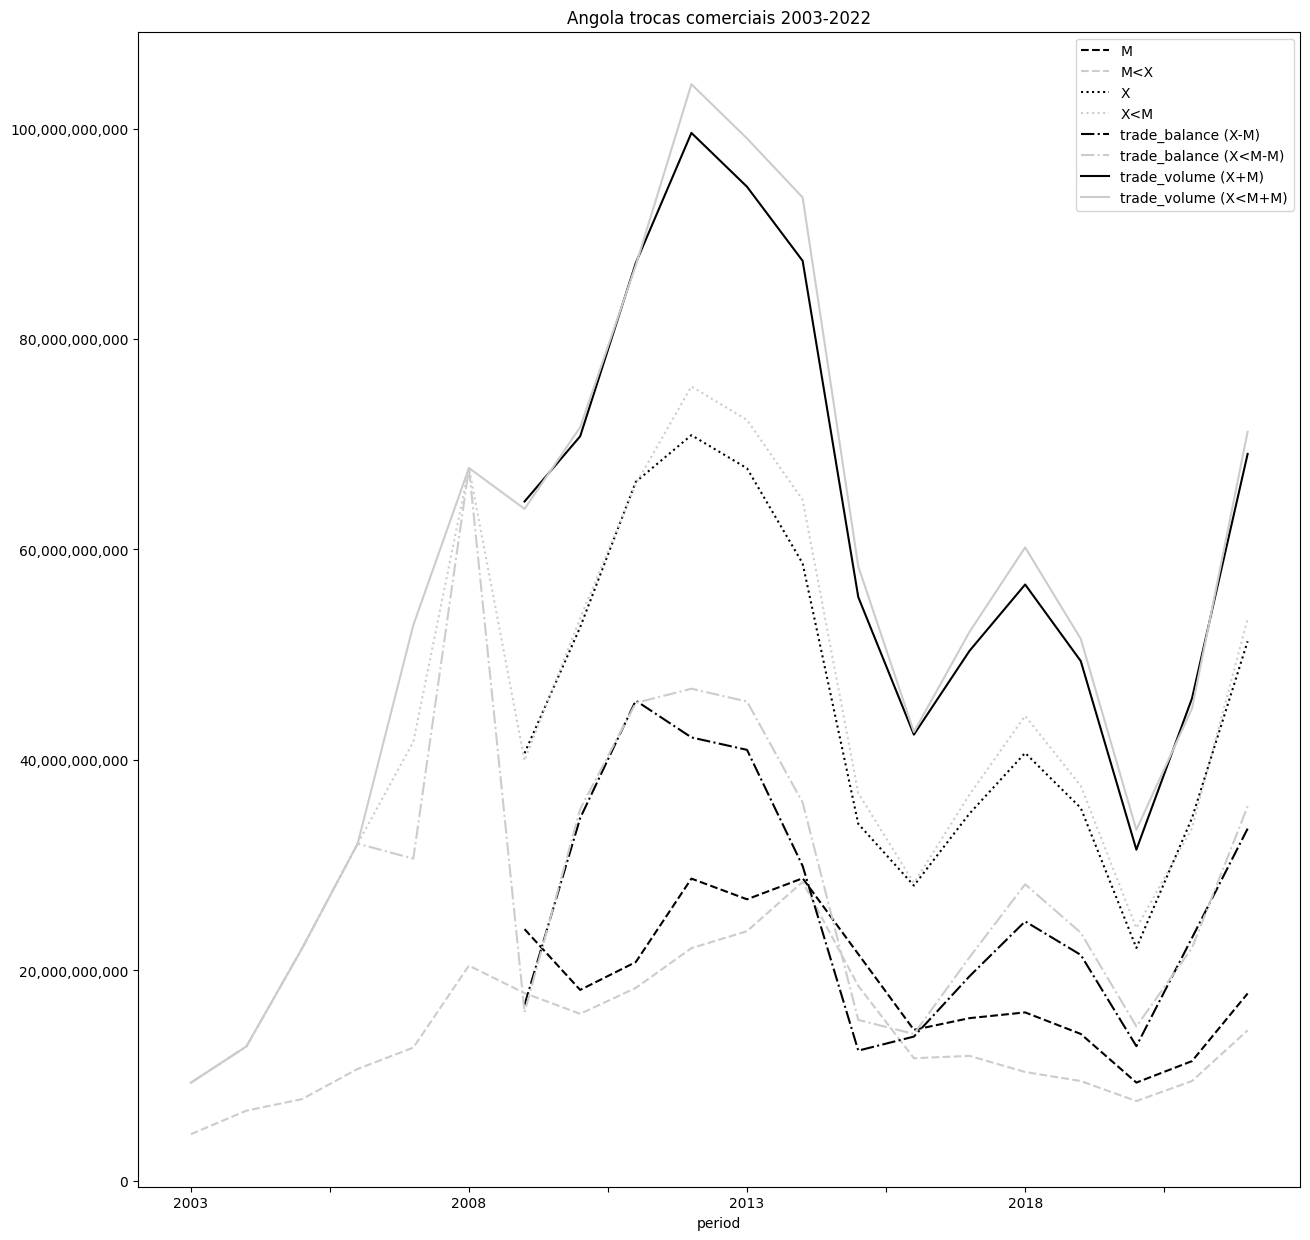

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

start_year=global_trade.index.min()
end_year=global_trade.index.max()
title=f"{country_of_interest_name} trocas comerciais {start_year}-{end_year}"
plotfile = f"reports/{country_of_interest_name}_trade_balance_{start_year}-{end_year}.png"
fig = global_trade[cols_of_interest].plot.line(figsize=(15,15),title=title)

# use a grayscale palette of colors
colors = ['0.0','0.8','0.0','0.8','0.0','0.8','0.0','0.8']

# use different line styles and black lines
linestyles = ['dashed', 'dashed', 'dotted', 'dotted', 'dashdot', 'dashdot', 'solid', 'solid']
for i, line in enumerate(fig.get_lines()):
    print(i, line, colors[i])
    line.set_color(colors[i])
    line.set_linestyle(linestyles[i % len(linestyles)])

formatter = ticker.StrMethodFormatter('{x:,.0f}')
fig.yaxis.set_major_formatter(formatter)
fig.legend(list(global_trade.columns.astype(str)))

plt.savefig(plotfile)
plt.show()

## Exports


### Main export partners of the country

Colect destinations of exports of the country. Use either reported exports
of country of interest, or reported imports from country of interest by
all other countries (symmetric reporting). Use variable `symmetric_reporting` to choose.

In [24]:

# If symmetric_reporting is "True" we get the exports from 
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world 
#    for import data from Country of Interest

symmetric_reporting = True  # set to false to use reported exports by Country of Interest

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'M'
    reporter_column = 'partner'
    partner_column = 'reporter'
else:
    reporterCode = country_of_interest
    partnerCode = None
    flowCode = 'X'
    reporter_column = 'reporter'
    partner_column = 'partner'

# Or we can take declared exports by Country of Interest
# reporterCode, partnerCode, flowCode, reporter = country_of_interest, None,'X', 'reporter'

# years_of_interest = comtrade.year_range(2020, 2021)  
df = comtradetools.getFinalData(APIKEY,
                                reporterCode=reporterCode,
                                typeCode='C',  # commodities
                                freqCode='A',  # annual
                                flowCode=flowCode,
                                period=years_of_interest,
                                partnerCode=partnerCode,
                                remove_world=True,
                                partner2Code=0,  # world
                                clCode="HS",
                                cmdCode="TOTAL",
                                motCode=0,  # all means of transport
                                customsCode='C00', # all customs
                                includeDesc=True,        
                                cache=True             
                                )

INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
INFO:root:Calling getFinalData for period 2015,2016,2017,2018,2019,2020,2021,2022,2023


Compute percentage o trade and rank of partners for each year.

Use `show_only_top` to show only the top partners (e.g. 5).

In [25]:
import pandas as pd
import comtradetools
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5 

# aggregate by year, flow, reporter 
exports = comtradetools.total_rank_perc(df,groupby=['refYear','flowCode',f'{partner_column}Desc'],
                                   col='primaryValue',
                                   prefix='partner',
                                   drop_duplicates=True)

cols=['refYear','flowCode',f'{partner_column}Desc','cmdCode','partner_upper_sum','partner_sum','partner_rank','partner_perc','partner_upper_perc']

formats =  comtradetools.make_format(cols)

top_export_partners = exports[exports['partner_rank']<=show_only_top][f'{partner_column}Desc'].unique()
top_export_partners_codes = exports[exports['partner_rank']<=show_only_top][f'{partner_column}Code'].unique()

print(f"Top {show_only_top} export partners of {country_of_interest_name} in {years_of_interest}: \n{top_export_partners}")
exports[exports['partner_rank']<=show_only_top][cols].sort_values(['refYear','flowCode','partner_rank',f'{partner_column}Desc','cmdCode']).style.format(formats)

Top 5 export partners of Angola in 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023: 
['China' 'France' 'Rep. of Korea' 'Other Asia, nes' 'USA' 'Chile'
 'South Africa' 'Canada' 'India' 'Portugal' 'Spain' 'United Arab Emirates'
 'Thailand' 'Netherlands']


,refYear,flowCode,reporterDesc,cmdCode,partner_upper_sum,partner_sum,partner_rank,partner_perc,partner_upper_perc
88,2003,M,USA,TOTAL,"$9,322,134,085","$4,508,909,969",1,48.368%,48.368%
10,2003,M,China,TOTAL,"$9,322,134,085","$2,205,934,880",2,23.663%,23.663%
50,2003,M,"Other Asia, nes",TOTAL,"$9,322,134,085","$754,817,300",3,8.097%,8.097%
25,2003,M,France,TOTAL,"$9,322,134,085","$693,959,478",4,7.444%,7.444%
42,2003,M,Rep. of Korea,TOTAL,"$9,322,134,085","$267,633,814",5,2.871%,2.871%
185,2004,M,USA,TOTAL,"$12,774,810,412","$4,796,799,975",1,37.549%,37.549%
108,2004,M,China,TOTAL,"$12,774,810,412","$4,717,339,146",2,36.927%,36.927%
144,2004,M,"Other Asia, nes",TOTAL,"$12,774,810,412","$864,305,200",3,6.766%,6.766%
122,2004,M,France,TOTAL,"$12,774,810,412","$815,351,242",4,6.382%,6.382%
107,2004,M,Chile,TOTAL,"$12,774,810,412","$430,833,024",5,3.373%,3.373%


Pivot the countries to columns, keeping the total value and percentage in separate columns.

----

Passamos os países para colunas, mantendo a percentagem e o valor em separado.

In [26]:
pivoted = df.pivot_table(index=['refYear','flowDesc'], columns=f'{partner_column}Desc', values=['primaryValue','partner_perc'])
pivoted.swaplevel(axis=1).fillna('',inplace=True)
pivoted.sort_index(axis=1, level=0, inplace=True)
pivoted.fillna(0)

partner_perc                                              \
reporterDesc          Albania Algeria Angola Anguilla Antigua and Barbuda   
refYear flowDesc                                                            
2003    Import           0.00    0.00   0.00     0.00                0.00   
2004    Import           0.00    0.00   0.00     0.00                0.00   
2005    Import           0.00    0.00   0.00     0.00                0.00   
2006    Import           0.00    0.00   0.00     0.00                0.00   
2007    Import           0.00    0.00   0.00     0.00                0.00   
2008    Import           0.00    0.00   0.00     0.00                0.00   
2009    Import           0.00    0.00   0.00     0.00                0.00   
2010    Import           0.00    0.00   0.00     0.00                0.00   
2011    Import           0.00    0.00   0.00     0.00                0.00   
2012    Import           0.00    0.00   0.00     0.00                0.00   
2013    Import           0.00    0.00   0.00     0.00                0.00   
2014    Import           0.00    0.00   0.00     0.00                0.00   
2015    Import           0.00    0.00   0.00     0.00                0.00   
2016    Import           0.00    0.00   0.00     0.00                0.00   
2017    Import           0.00    0.00   0.00     0.00                0.00   
2018    Import           0.00    0.00   0.00     0.00                0.00   
2019    Import           0.00    0.00   0.00     0.00                0.00   
2020    Import           0.00    0.00   0.00     0.00                0.00   
2021    Import           0.00    0.00   0.00     0.00                0.00   
2022    Import           0.00    0.00   0.00     0.00                0.00   

                                                                 ...  \
reporterDesc     Argentina Armenia Australia Austria Azerbaijan  ...   
refYear flowDesc                                                 ...   
2003    Import        0.00    0.00      0.00    0.00       0.00  ...   
2004    Import        0.00    0.00      0.00    0.00       0.00  ...   
2005    Import        0.00    0.00      0.00    0.00       0.00  ...   
2006    Import        0.00    0.00      0.00    0.00       0.00  ...   
2007    Import        0.00    0.00      0.00    0.00       0.00  ...   
2008    Import        0.00    0.00      0.00    0.00       0.00  ...   
2009    Import        0.00    0.00      0.00    0.00       0.00  ...   
2010    Import        0.00    0.00      0.00    0.00       0.00  ...   
2011    Import        0.00    0.00      0.00    0.00       0.00  ...   
2012    Import        0.00    0.00      0.00    0.00       0.00  ...   
2013    Import        0.00    0.00      0.00    0.00       0.00  ...   
2014    Import        0.00    0.00      0.00    0.00       0.00  ...   
2015    Import        0.00    0.00      0.00    0.00       0.00  ...   
2016    Import        0.00    0.00      0.00    0.00       0.00  ...   
2017    Import        0.00    0.00      0.00    0.00       0.00  ...   
2018    Import        0.00    0.00      0.00    0.00       0.00  ...   
2019    Import        0.00    0.00      0.00    0.00       0.00  ...   
2020    Import        0.00    0.00      0.00    0.00       0.00  ...   
2021    Import        0.00    0.00      0.00    0.00       0.00  ...   
2022    Import        0.00    0.00      0.00    0.00       0.00  ...   

                         primaryValue                   \
reporterDesc     United Arab Emirates   United Kingdom   
refYear flowDesc                                         
2003    Import             239,672.00     3,813,092.00   
2004    Import             373,161.00     5,618,405.00   
2005    Import          23,098,892.00    15,585,564.00   
2006    Import          62,722,666.00     4,891,796.00   
2007    Import         277,908,013.00   356,113,855.00   
2008    Import         544,451,118.00 1,061,279,633.00   
2009    Import          92,225,082.00   422,687,442.00   
2010    

Limit table to top_export_partners

Note that the number of top partners considered was set before with `show_only_top` (e.g. 5).

But each year the top partners may vary, so that the total number of partners for the period will be
more than `show_only_top`.

In [32]:
show_only_columns = [(l1, country) for l1,country in pivoted.columns.tolist() if country in top_export_partners]
pivoted[show_only_columns]

partner_perc                                       \
reporterDesc           Canada Chile China France India Netherlands   
refYear flowDesc                                                     
2003    Import           0.00  0.01  0.24   0.07   NaN        0.00   
2004    Import           0.00  0.03  0.37   0.06  0.00        0.00   
2005    Import           0.01  0.05  0.30   0.08  0.00        0.00   
2006    Import           0.02  0.04  0.34   0.05  0.01        0.00   
2007    Import           0.03  0.02  0.31   0.06  0.02        0.02   
2008    Import           0.04  0.02  0.33   0.06  0.02        0.03   
2009    Import           0.03  0.00  0.37   0.08  0.08        0.02   
2010    Import           0.03  0.00  0.43   0.04  0.09        0.01   
2011    Import           0.04  0.00  0.38   0.03  0.09        0.01   
2012    Import           0.03  0.00  0.44   0.02  0.11        0.01   
2013    Import           0.02  0.00  0.44   0.02  0.09        0.02   
2014    Import           0.02  0.01  0.48   0.03  0.09        0.02   
2015    Import           0.01  0.00  0.43   0.04  0.09        0.01   
2016    Import           0.00  0.00  0.49   0.04  0.07        0.01   
2017    Import           0.00  0.00  0.56   0.01  0.11        0.00   
2018    Import           0.00  0.00  0.58   0.01  0.10        0.00   
2019    Import           0.00  0.01  0.63   0.01  0.10        0.00   
2020    Import           0.00  0.00  0.61   0.02  0.08        0.01   
2021    Import           0.00  0.02  0.62   0.01  0.07        0.01   
2022    Import           0.00  0.01  0.44   0.07  0.07        0.09   

                                                                      ...  \
reporterDesc     Other Asia, nes Portugal Rep. of Korea South Africa  ...   
refYear flowDesc                                                      ...   
2003    Import              0.08     0.00          0.03         0.00  ...   
2004    Import              0.07     0.00          0.01         0.02  ...   
2005    Import              0.04     0.00          0.00         0.01  ...   
2006    Import              0.06     0.00          0.01         0.01  ...   
2007    Import              0.05     0.01          0.01         0.04  ...   
2008    Import              0.03     0.01          0.00         0.04  ...   
2009    Import              0.03     0.01          0.00         0.03  ...   
2010    Import              0.05     0.01          0.00         0.04  ...   
2011    Import              0.09     0.02          0.00         0.02  ...   
2012    Import              0.07     0.03          0.00         0.04  ...   
2013    Import              0.05     0.05          0.00         0.03  ...   
2014    Import              0.05     0.03          0.00         0.03  ...   
2015    Import              0.04     0.03          0.00         0.04  ...   
2016    Import              0.05     0.03          0.01         0.05  ...   
2017    Import              0.04     0.01          0.01         0.04  ...   
2018    Import              0.01     0.03          0.00         0.03  ...   
2019    Import              0.01     0.03          0.00         0.02  ...   
2020    Import              0.02     0.02          0.01         0.00  ...   
2021    Import              0.01     0.00          0.00         0.01  ...   
2022    Import              0.02     0.01          0.00         0.01  ...   

                     primaryValue                                    \
reporterDesc                India      Netherlands  Other Asia, nes   
refYear flowDesc                                                      
2003    Import                NaN    21,261,447.00   754,817,300.00   
2004    Import         660,762.00     3,883,632.00   864,305,200.00   
2005    Import       2,830,007.00    76,870,172.00   983,486,568.00   
2006    Import     183,066,968.00    61,030,974.00 1,866,922,218.00   
2007    Import     920,236,282.00   754,858,701.00 2,121,461,485.00   
2008    Import   1,289,284,732.00 1,857,436,139.00 2,012,656,414.0

Make a table with the total value of import for top partners in the period of interest

In [33]:
print("Top partners for exports: ",top_export_partners)
print("Period of interest:",years_of_interest)

Top partners for exports:  ['China' 'France' 'Rep. of Korea' 'Other Asia, nes' 'USA' 'Chile'
 'South Africa' 'Canada' 'India' 'Portugal' 'Spain' 'United Arab Emirates'
 'Thailand' 'Netherlands']
Period of interest: 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023


In [29]:
import pandas as pd

# lets get just the value of imports from the top export partners
values_only = pivoted.loc[:,"primaryValue"]
values_only.reset_index(level=1, drop=True, inplace=True)
show_only_columns = [country for country in values_only.columns.tolist() if country in top_export_partners]
values_only=values_only[show_only_columns]
# sort columns by mean value
mean_values = values_only.mean().sort_values(ascending=False)
values_only = values_only[mean_values.index]
values_only

reporterDesc,China,USA,India,"Other Asia, nes",France,Spain,South Africa,Portugal,United Arab Emirates,Canada,Netherlands,Thailand,Chile,Rep. of Korea
refYear,,,,,,,,,,,,,,
2003,"2,205,934,880.00","4,508,909,969.00",NaN,"754,817,300.00","693,959,478.00","33,421,762.46","3,838,410.00","2,715,617.00","239,672.00","34,240.00","21,261,447.00","1,922,333.00","64,495,998.58","267,633,814.00"
2004,"4,717,339,146.00","4,796,799,975.00","660,762.00","864,305,200.00","815,351,242.00","209,277,237.91","262,218,735.00","2,275,466.00","373,161.00","37,661.00","3,883,632.00","3,661,927.00","430,833,023.99","137,397,995.00"
2005,"6,581,828,714.00","8,846,626,689.00","2,830,007.00","983,486,568.00","1,749,100,644.00","674,568,529.17","296,956,332.00","31,255,288.00","23,098,892.00","274,661,091.00","76,870,172.00","113,805,148.00","1,197,146,448.25","681,486.00"
2006,"10,933,295,107.00","12,174,574,006.00","183,066,968.00","1,866,922,218.00","1,553,209,281.00","472,603,923.93","366,028,810.00","66,234,967.00","62,722,666.00","534,404,069.00","61,030,974.00","137,031,002.00","1,317,205,507.86","218,670,939.00"
2007,"12,888,664,603.00","12,925,965,219.00","920,236,282.00","2,121,461,485.00","2,370,503,388.00","659,539,918.85","1,645,793,847.00","507,093,777.00","277,908,013.00","1,117,813,799.00","754,858,701.00","89,534,654.00","962,541,529.46","342,584,832.00"
2008,"22,382,523,829.00","19,497,727,584.00","1,289,284,732.00","2,012,656,414.00","4,010,271,285.00","1,801,425,480.21","2,686,472,634.00","600,969,680.00","544,451,118.00","2,607,324,781.00","1,857,436,139.00","1,882,124.00","1,671,247,631.27","743,442.00"
2009,"14,675,830,702.00","9,703,060,917.00","3,394,217,299.00","1,058,623,864.00","3,270,520,333.00","769,183,025.04","1,370,601,054.00","211,175,103.00","92,225,082.00","1,207,221,890.00","649,134,968.00","635,558.00","42,462,874.10","118,154,628.00"
2010,"22,815,049,454.00","12,273,944,969.00","4,838,456,716.00","2,859,560,967.00","2,126,302,876.00","621,951,979.45","2,001,779,408.82","746,364,900.00","189,747,877.00","1,575,913,884.00","621,769,714.00","83,217,295.00","164,064.56","114,382,916.00"
2011,"24,922,180,492.00","13,833,012,040.00","6,005,484,849.00","5,665,315,729.00","1,825,704,019.00","587,380,397.71","1,586,176,196.93","1,639,710,523.00","301,582,058.00","2,469,608,910.00","933,906,994.74","457,444.00","345,366.42","2,528,752.00"


0 Line2D(_child0) crimson
1 Line2D(_child2) darkorange
2 Line2D(_child4) gold
3 Line2D(_child6) limegreen
4 Line2D(_child8) mediumseagreen
5 Line2D(_child10) teal
6 Line2D(_child12) deepskyblue
7 Line2D(_child14) royalblue
8 Line2D(_child16) indigo
9 Line2D(_child18) mediumvioletred
10 Line2D(_child20) hotpink
11 Line2D(_child22) saddlebrown
12 Line2D(_child24) grey
13 Line2D(_child26) black


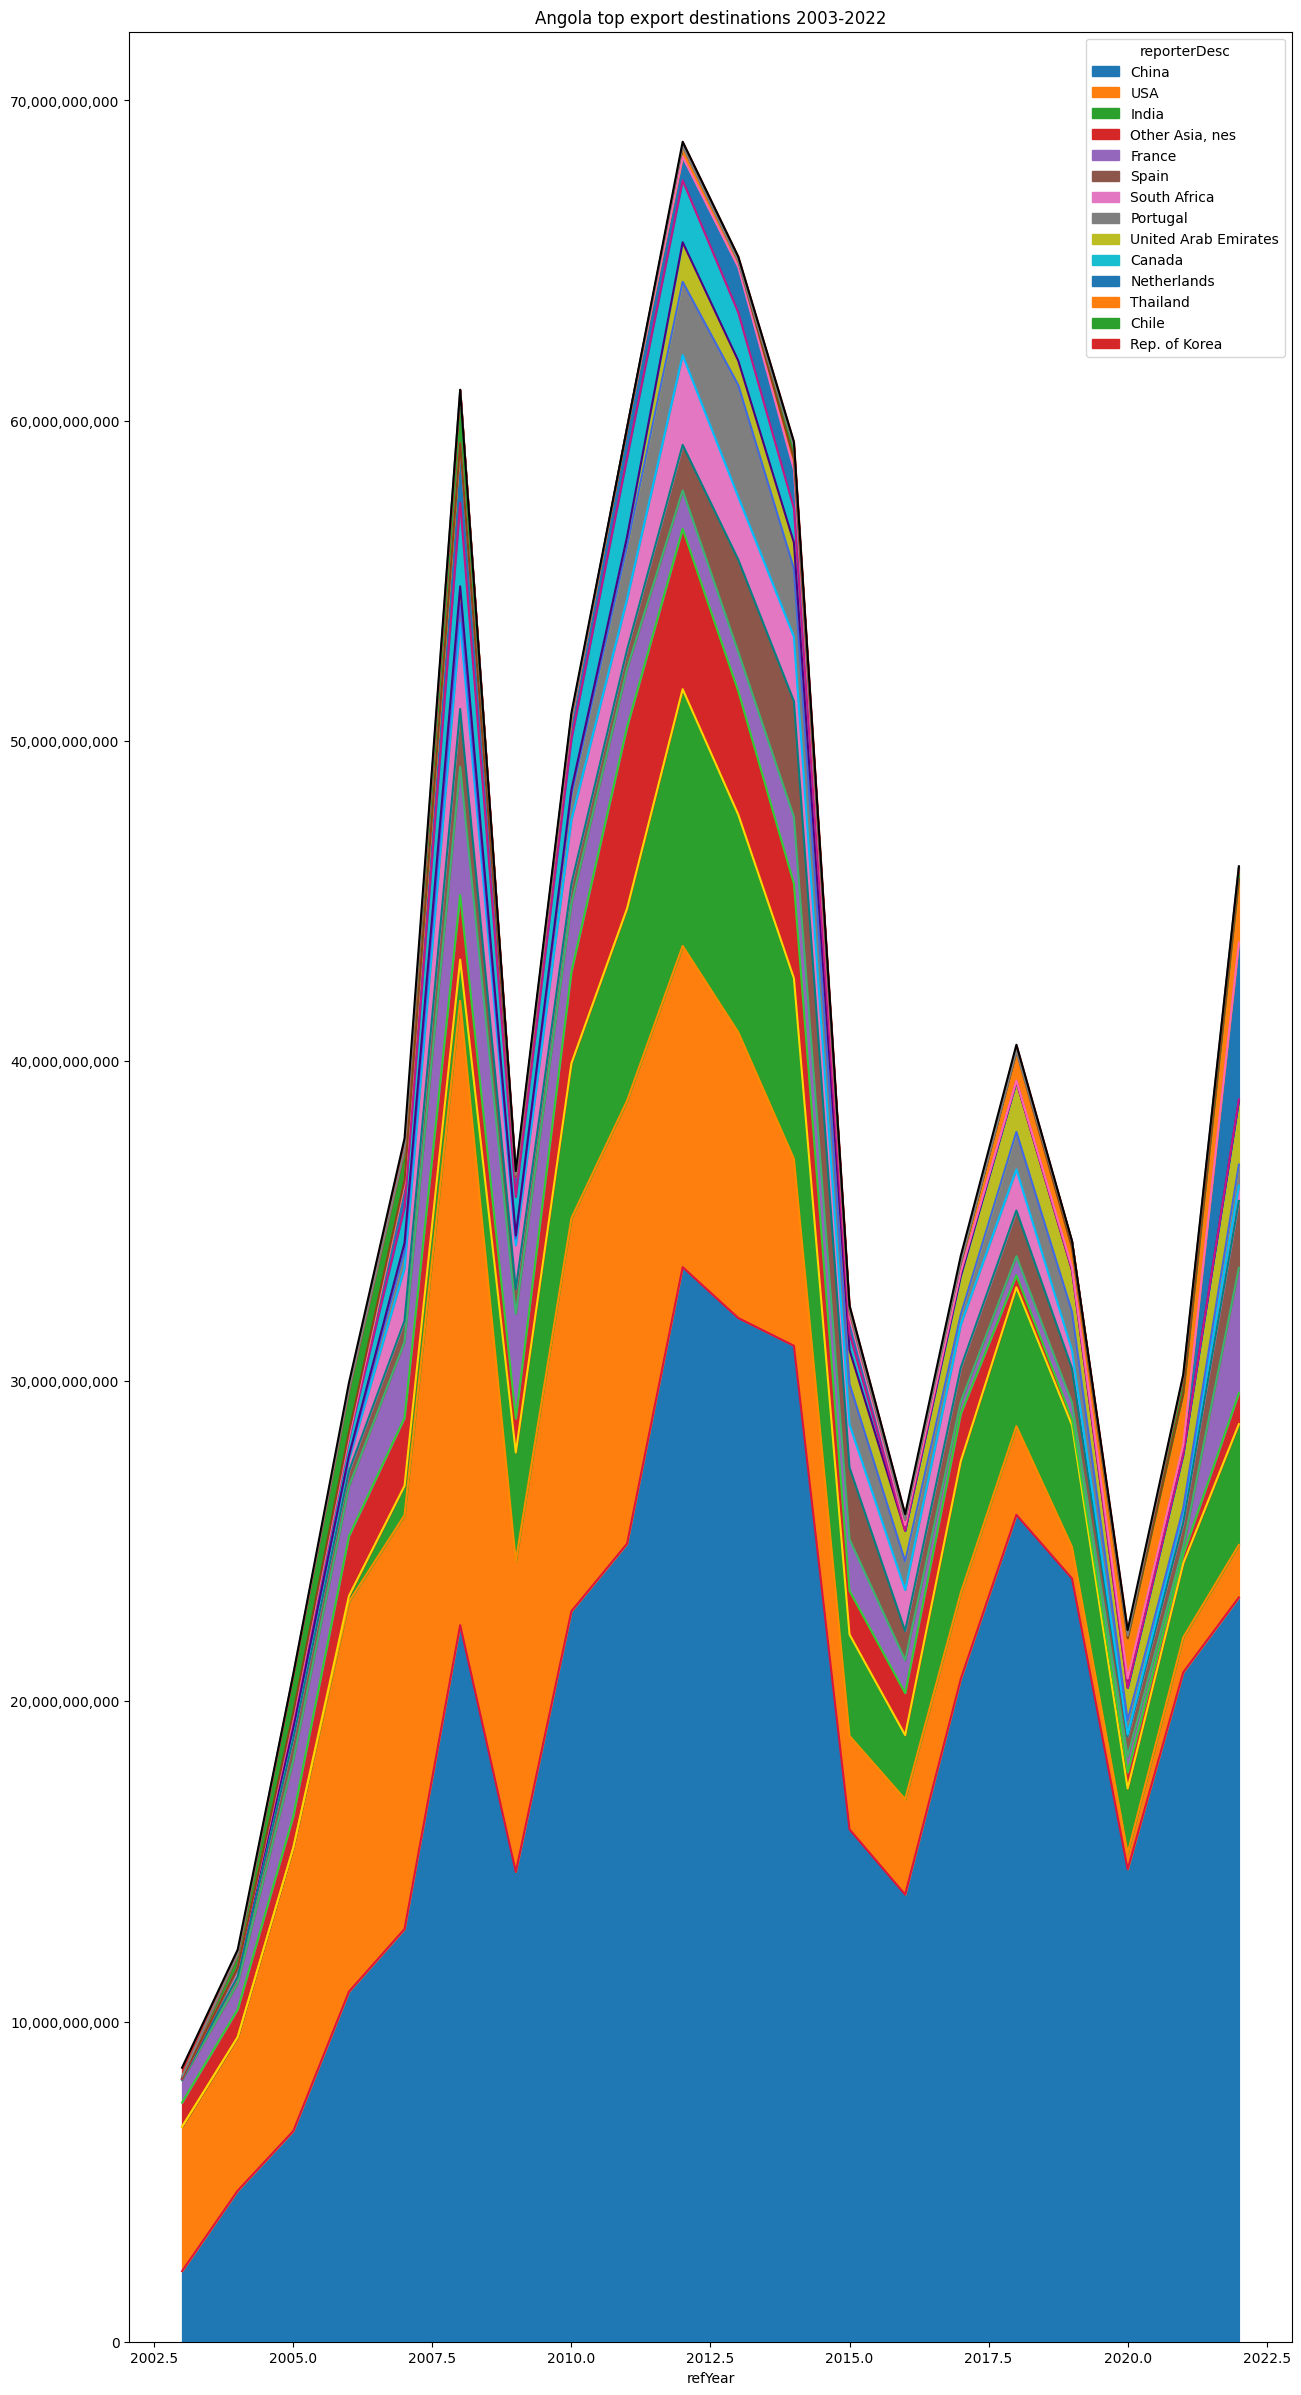

<Figure size 640x480 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

start_year=values_only.index.min()
end_year=values_only.index.max()
title=f"{country_of_interest_name} top export destinations {start_year}-{end_year}"
plotfile = f"reports/{country_of_interest_name}_export_partners_{start_year}-{end_year}.png"
fig2 = values_only.plot.area(figsize=(15,30),title=title)
# see https://matplotlib.org/stable/gallery/color/named_colors.html
# colors = ['red','lightsalmon','green','lightgreen','darkviolet','violet','blue','dodgerblue','orange','yellow','brown','black','grey','pink','cyan','magenta',]
colors = ['crimson', 'darkorange', 'gold', 'limegreen', 'mediumseagreen', 'teal', 'deepskyblue', 'royalblue', 'indigo', 'mediumvioletred', 'hotpink', 'saddlebrown', 'grey', 'black', 'darkslategrey', 'darkkhaki']
for i, line in enumerate(fig2.get_lines()):
    n = i % len(colors)
    print(i, line, colors[n])
    line.set_color(colors[n])

formatter = ticker.StrMethodFormatter('{x:,.0f}')
fig2.yaxis.set_major_formatter(formatter)


plt.show()
plt.savefig(plotfile)

In [31]:
show_only_columns = [(l1, country) for l1,country in pivoted.columns.tolist() if country in top_export_partners]
show_only_columns

[('partner_perc', 'Canada'),
 ('partner_perc', 'Chile'),
 ('partner_perc', 'China'),
 ('partner_perc', 'France'),
 ('partner_perc', 'India'),
 ('partner_perc', 'Netherlands'),
 ('partner_perc', 'Other Asia, nes'),
 ('partner_perc', 'Portugal'),
 ('partner_perc', 'Rep. of Korea'),
 ('partner_perc', 'South Africa'),
 ('partner_perc', 'Spain'),
 ('partner_perc', 'Thailand'),
 ('partner_perc', 'USA'),
 ('partner_perc', 'United Arab Emirates'),
 ('primaryValue', 'Canada'),
 ('primaryValue', 'Chile'),
 ('primaryValue', 'China'),
 ('primaryValue', 'France'),
 ('primaryValue', 'India'),
 ('primaryValue', 'Netherlands'),
 ('primaryValue', 'Other Asia, nes'),
 ('primaryValue', 'Portugal'),
 ('primaryValue', 'Rep. of Korea'),
 ('primaryValue', 'South Africa'),
 ('primaryValue', 'Spain'),
 ('primaryValue', 'Thailand'),
 ('primaryValue', 'USA'),
 ('primaryValue', 'United Arab Emirates')]

#### Export to Excel

Table with the top export destinations for the period of interest

In [19]:
top_partners_file = f'reports/{country_of_interest_name}_top_partners.xlsx'
top_partners_cols_file = f'reports/{country_of_interest_name}_top_partners_cols.xlsx'
export_top_partners_file = f'reports/{country_of_interest_name}_export_top_{show_only_top}_partners_{start_year}-{end_year}.xlsx'

exports.to_excel(top_partners_file)
pivoted.to_excel(top_partners_cols_file)
pivoted[show_only_columns].to_excel(export_top_partners_file)

print(f"Top partners file: {top_partners_file}")
print(f"Top partners cols file: {top_partners_cols_file}")
print(f"Export top partners file: {export_top_partners_file}")

Top partners file: reports/Angola_top_partners.xlsx
Top partners cols file: reports/Angola_top_partners_cols.xlsx
Export top partners file: reports/Angola_export_top_5_partners_2007-2022.xlsx


## Exports: products

### Main exported products

In [21]:
import pandas as pd

# show 500 lines of dataframes
pd.set_option('display.max_rows', 500)

show_only_top=5
# years_of_interest = comtrade.year_range(2020, 2021)  


Get the products exported by country of interest

In [38]:

# If symmetric_reporting is "True" we get the exports from 
#    the reported imports of all the countries
# i.e. instead of asking Country of Interest for export data we ask the world 
#    for import data from Country of Interest

symmetric_reporting = False  # set to false to use reported exports by Country of Interest

if symmetric_reporting:
    reporterCode = None
    partnerCode = country_of_interest
    flowCode = 'M'
    reporter_column = 'partner'
    partner_column = 'reporter'
else:
    reporterCode = country_of_interest
    partnerCode = 0
    flowCode = 'X'
    reporter_column = 'reporter'
    partner_column = 'partner'



        # years_of_interest = comtrade.year_range(2020, 2021)  
        df = comtradetools.getFinalData(APIKEY,
                                        reporterCode=reporterCode,
                                        typeCode='C',  # commodities
                                        freqCode='A',  # annual
                                        flowCode=flowCode,
                                        period=years_of_interest,
                                        partnerCode=partnerCode,
                                        remove_world=True,
                                        partner2Code=0,  # world
                                        clCode="HS",
                                        cmdCode="TOTAL",
                                        motCode=0,  # all means of transport
                                        customsCode='C00', # all customs
                                        includeDesc=True,        
                                        cache=True             
                                        )

In [42]:
import comtradetools

clCode = 'HS'
cmdDetail = 'AG6'  # AG2 aggregate two digits, top level, AG4 detail 4 digits, ... World bank uses AG6
df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=reporterCode,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode=flowCode,
                        period=years_of_interest,
                        partnerCode=partnerCode,
                        remove_world=False,
                        partner2Code=0,
                        clCode=clCode,
                        cmdCode=cmdDetail,  
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        cache=True   
                        )

INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014


KeyboardInterrupt: 

In [109]:
df.head()

,typeCode,freqCode,refPeriodId,refYear,refMonth,period,reporterCode,reporterISO,reporterDesc,flowCode,...,netWgt,isNetWgtEstimated,grossWgt,isGrossWgtEstimated,cifvalue,fobvalue,primaryValue,legacyEstimationFlag,isReported,isAggregate
0,C,A,20070101,2007,52,2007,24,AGO,Angola,X,...,"7,000,343.00",False,NaN,False,None,"42,575,360.00","42,575,360.00",0,True,False
1,C,A,20070101,2007,52,2007,24,AGO,Angola,X,...,"238,878,000.00",False,NaN,False,None,"413,269.00","413,269.00",0,True,False
2,C,A,20070101,2007,52,2007,24,AGO,Angola,X,...,"1,288,118,742.00",False,NaN,False,None,"666,333,579.00","666,333,579.00",0,True,False
3,C,A,20070101,2007,52,2007,24,AGO,Angola,X,...,"96,117,049,344.00",False,NaN,False,None,"42,286,185,648.00","42,286,185,648.00",0,True,False
4,C,A,20070101,2007,52,2007,24,AGO,Angola,X,...,"833,814.00",True,NaN,False,None,"331,253.00","331,253.00",4,True,False


In [25]:
import pandas as pd
import comtradetools
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5 
exports = comtradetools.total_rank_perc(df,['refYear','flowCode','cmdCode'],'primaryValue','product',drop_duplicates=True)
exports = exports[exports['product_rank']<=show_only_top]

cols=['refYear','flowCode','cmdCode','product_sum','product_rank','product_perc','product_upper_sum', 'cmdDesc']
formats =  comtradetools.make_format(cols)

top_import_products_codes = exports['cmdCode'].unique()

print(f"Top products exported by {country_of_interest_name} in {years_of_interest}:\n {top_import_products_codes}")
for cmdCode in top_import_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")
exports[cols].sort_values(['refYear','flowCode','product_rank']).style.format(formats)


Top products exported by Angola in 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023:
 ['030219' '090111' '270740' '270900' '710221' '440310' '251512' '890520'
 '271012' '271111' '271112' '890690' '890190' '890590']
   030219: Fish; fresh or chilled, salmonidae, n.e.c. in item no. 0302.1, excluding fillets, fish meat of 0304, and edible fish offal of subheadings 0302.91 to 0302.99
   090111: Coffee; not roasted or decaffeinated
   270740: Oils and products of the distillation of high temperature coal tar; naphthalene
   270900: Oils; petroleum oils and oils obtained from bituminous minerals, crude
   710221: Diamonds; industrial, unworked or simply sawn, cleaved or bruted, but not mounted or set
   440310: 440310
   251512: Marble and travertine; merely cut, by sawing or otherwise, into blocks or slabs of a rectangular (including square) shape, having a specific gravity of 2.5 or more
   890520: Floating or submersible drilling or 

,refYear,flowCode,cmdCode,product_sum,product_rank,product_perc,product_upper_sum,cmdDesc
3,2007,X,270900,"$42,286,185,648",1,95.718%,"$44,177,783,071","Oils; petroleum oils and oils obtained from bituminous minerals, crude"
5,2007,X,710221,"$1,181,943,962",2,2.675%,"$44,177,783,071","Diamonds; industrial, unworked or simply sawn, cleaved or bruted, but not mounted or set"
2,2007,X,270740,"$666,333,579",3,1.508%,"$44,177,783,071",Oils and products of the distillation of high temperature coal tar; naphthalene
0,2007,X,030219,"$42,575,360",4,0.096%,"$44,177,783,071","Fish; salmonidae, fresh or chilled, n.e.s. in item no. 0302.1 (excluding fillets, livers, roes and other fish meat of heading no. 0304)"
1,2007,X,090111,"$413,269",5,0.001%,"$44,177,783,071",Coffee; not roasted or decaffeinated
9,2009,X,270900,"$39,262,457,163",1,96.612%,"$40,639,411,732","Oils; petroleum oils and oils obtained from bituminous minerals, crude"
11,2009,X,710221,"$813,613,812",2,2.002%,"$40,639,411,732","Diamonds; industrial, unworked or simply sawn, cleaved or bruted, but not mounted or set"
8,2009,X,270740,"$530,171,435",3,1.305%,"$40,639,411,732",Oils and products of the distillation of high temperature coal tar; naphthalene
6,2009,X,030219,"$32,169,994",4,0.079%,"$40,639,411,732","Fish; salmonidae, fresh or chilled, n.e.c. in item no. 0302.1 (excluding fillets, livers, roes and other fish meat of heading no. 0304)"
7,2009,X,090111,"$810,420",5,0.002%,"$40,639,411,732",Coffee; not roasted or decaffeinated


#### Export to Excel

In [26]:
exports.to_excel(f'reports/{country_of_interest_name}_exports_products_{clCode}-{cmdDetail}-{exports["refYear"].min()}-{exports["refYear"].max()}.xlsx',index=False)

## Export partners / products analysis

What are the partners buying the top exports of country of interest?


In [27]:
df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=country_of_interest,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode='X',
                        partnerCode=None,
                        remove_world=True,
                        partner2Code=0,
                        period=years_of_interest,
                        period_size=6,
                        clCode=clCode,
                        cmdCode=cmdDetail,  
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        cache=True   
                        )

INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008
INFO:root:Calling getFinalData for period 2009,2010,2011,2012,2013,2014
INFO:root:Calling getFinalData for period 2015,2016,2017,2018,2019,2020
INFO:root:Calling getFinalData for period 2021,2022,2023


In [28]:
import pandas as pd
import comtradetools

# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 5 
print(f"Top products exported by {country_of_interest_name} in {years_of_interest}:\n {top_import_products_codes}")
for cmdCode in top_import_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")

print(f"Top export partners ({len(top_export_partners)}): {top_export_partners}")
prefix='cmd_partner'
# remove world
if 0 in df[f'{partner_column}Code']:
    warnings.warning("Removing world from data")
products_and_partners = comtradetools.total_rank_perc(df,['refYear','flowCode','cmdCode',f'{partner_column}Code'],'primaryValue',prefix,drop_duplicates=True)

cols=['refYear','flowCode','cmdDesc','cmdCode',f'{partner_column}Desc',f'{prefix}_sum',f'{prefix}_rank',f'{prefix}_upper_sum',f'{prefix}_perc']
formats=comtradetools.make_format(cols)
products_and_partners=products_and_partners[(products_and_partners['cmdCode'].isin(top_import_products_codes) 
                       & (products_and_partners[f'{prefix}_rank']<=show_only_top))]


Top products exported by Angola in 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023:
 ['030219' '090111' '270740' '270900' '710221' '440310' '251512' '890520'
 '271012' '271111' '271112' '890690' '890190' '890590']
   030219: Fish; fresh or chilled, salmonidae, n.e.c. in item no. 0302.1, excluding fillets, fish meat of 0304, and edible fish offal of subheadings 0302.91 to 0302.99
   090111: Coffee; not roasted or decaffeinated
   270740: Oils and products of the distillation of high temperature coal tar; naphthalene
   270900: Oils; petroleum oils and oils obtained from bituminous minerals, crude
   710221: Diamonds; industrial, unworked or simply sawn, cleaved or bruted, but not mounted or set
   440310: 440310
   251512: Marble and travertine; merely cut, by sawing or otherwise, into blocks or slabs of a rectangular (including square) shape, having a specific gravity of 2.5 or more
   890520: Floating or submersible drilling or 

### Partners for main export products

In [29]:
products_and_partners[cols].sort_values(['refYear','flowCode',f'{prefix}_upper_sum',f'{prefix}_rank'],
                                         ascending=[True,True,False,True])\
                                            .head(10).style.format(formats) #.hide(axis='index')

,refYear,flowCode,cmdDesc,cmdCode,partnerDesc,cmd_partner_sum,cmd_partner_rank,cmd_partner_upper_sum,cmd_partner_perc
32,2007,X,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,China,"$13,359,145,253",1,"$42,286,185,648",31.592%
46,2007,X,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,USA,"$10,667,166,235",2,"$42,286,185,648",25.226%
30,2007,X,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,Canada,"$2,913,186,035",3,"$42,286,185,648",6.889%
34,2007,X,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,France,"$2,555,982,630",4,"$42,286,185,648",6.044%
42,2007,X,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,India,"$2,376,843,352",5,"$42,286,185,648",5.621%
62,2007,X,"Diamonds; industrial, unworked or simply sawn, cleaved or bruted, but not mounted or set",710221,"Areas, nes","$398,073,485",1,"$1,181,943,964",33.680%
61,2007,X,"Diamonds; industrial, unworked or simply sawn, cleaved or bruted, but not mounted or set",710221,United Arab Emirates,"$378,529,191",2,"$1,181,943,964",32.026%
59,2007,X,"Diamonds; industrial, unworked or simply sawn, cleaved or bruted, but not mounted or set",710221,Israel,"$183,490,860",3,"$1,181,943,964",15.524%
57,2007,X,"Diamonds; industrial, unworked or simply sawn, cleaved or bruted, but not mounted or set",710221,Belgium,"$107,966,613",4,"$1,181,943,964",9.135%
58,2007,X,"Diamonds; industrial, unworked or simply sawn, cleaved or bruted, but not mounted or set",710221,China,"$60,837,355",5,"$1,181,943,964",5.147%


In [30]:
products_and_partners[cols].to_excel(f'reports/{country_of_interest_name}_exports_partners_{clCode}-{cmdDetail}-{products_and_partners["refYear"].min()}-{products_and_partners["refYear"].max()}.xlsx',index=False)

### Main partners and main products imported from country of interest

Detail of the main products by export partner.

Allows to analyse the mix of products of the main export partners from this country

In [31]:
top_export_partners

array(['Canada', 'China', 'France', 'India', 'USA', 'Other Asia, nes',
       'Italy', 'Spain', 'South Africa', 'Portugal',
       'United Arab Emirates', 'Thailand', 'Singapore', 'Netherlands'],
      dtype=object)

In [33]:
import comtradetools

print(f"Top export partners ({len(top_export_partners)}): {top_export_partners}")
prefix='partner_cmd'
partners_and_products = comtradetools.total_rank_perc(df,['refYear','flowCode',f'{partner_column}Code','cmdCode'],'primaryValue',prefix,drop_duplicates=False)

cols=['refYear','flowCode',f'{partner_column}Desc','cmdDesc','cmdCode',f'{prefix}_sum',f'{prefix}_rank',f'{prefix}_upper_sum',f'{prefix}_perc']
formats = comtradetools.make_format(cols)
partners_and_products=partners_and_products[(partners_and_products[f'{partner_column}Desc'].isin(top_export_partners) 
                       & (partners_and_products[f'{prefix}_rank']<=show_only_top))]


partners_and_products[partners_and_products[f'{prefix}_rank']<show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False]).head(10).style.format(formats).hide(axis='index')

Top export partners (14): ['Canada' 'China' 'France' 'India' 'USA' 'Other Asia, nes' 'Italy' 'Spain'
 'South Africa' 'Portugal' 'United Arab Emirates' 'Thailand' 'Singapore'
 'Netherlands']


refYear,flowCode,partnerDesc,cmdDesc,cmdCode,partner_cmd_sum,partner_cmd_rank,partner_cmd_upper_sum,partner_cmd_perc
2007,X,China,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,"$13,359,145,253",1,"$13,459,326,564",99.256%
2007,X,China,"Diamonds; industrial, unworked or simply sawn, cleaved or bruted, but not mounted or set",710221,"$60,837,355",2,"$13,459,326,564",0.452%
2007,X,China,Oils and products of the distillation of high temperature coal tar; naphthalene,270740,"$39,343,956",3,"$13,459,326,564",0.292%
2007,X,USA,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,"$10,667,166,235",1,"$10,875,646,624",98.083%
2007,X,USA,Oils and products of the distillation of high temperature coal tar; naphthalene,270740,"$208,480,389",2,"$10,875,646,624",1.917%
2007,X,Canada,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,"$2,913,186,035",1,"$2,913,186,035",100.000%
2007,X,France,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,"$2,555,982,630",1,"$2,592,972,628",98.573%
2007,X,France,Oils and products of the distillation of high temperature coal tar; naphthalene,270740,"$33,915,023",2,"$2,592,972,628",1.308%
2007,X,France,"Fish; salmonidae, fresh or chilled, n.e.s. in item no. 0302.1 (excluding fillets, livers, roes and other fish meat of heading no. 0304)",030219,"$3,030,916",3,"$2,592,972,628",0.117%
2007,X,France,"Wood; in the rough, whether or not stripped of bark or sapwood, or roughly squared; treated with paint, stains, creosote or other preservatives",440310,"$44,059",4,"$2,592,972,628",0.002%


In [34]:
partners_and_products[partners_and_products[f'{prefix}_rank']<show_only_top][cols].sort_values(
    ['refYear','flowCode','partner_cmd_upper_sum',f'{prefix}_sum',f'{prefix}_rank'],
    ascending=[True,True,False,False,False]).tail(10).style.format(formats).hide(axis='index')

refYear,flowCode,partnerDesc,cmdDesc,cmdCode,partner_cmd_sum,partner_cmd_rank,partner_cmd_upper_sum,partner_cmd_perc
2022,X,South Africa,"Glass; carboys, bottles, flasks, jars, pots, phials and other containers of glass, (not ampoules), used for the conveyance or packing of goods",701090,"$7,782,643",3,"$666,176,004",1.168%
2022,X,South Africa,Tugs and pusher craft,890400,"$5,390,717",4,"$666,176,004",0.809%
2022,X,USA,"Petroleum oils and oils from bituminous minerals, not containing biodiesel, not crude, not waste oils; preparations n.e.c, containing by weight 70% or more of petroleum oils or oils from bituminous minerals; light oils and preparations",271012,"$407,187,238",1,"$651,446,316",62.505%
2022,X,USA,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,"$194,026,455",2,"$651,446,316",29.784%
2022,X,USA,"Vessels; n.e.c. in heading no. 8901, for the transport of goods and other vessels for the transport of both persons and goods",890190,"$19,929,136",3,"$651,446,316",3.059%
2022,X,USA,"Machinery; parts of the machinery of heading no. 8428, (other than lifts, skip hoists or escalators)",843139,"$6,571,875",4,"$651,446,316",1.009%
2022,X,Singapore,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",270900,"$316,347,175",1,"$439,365,962",72.001%
2022,X,Singapore,"Petroleum gases and other gaseous hydrocarbons; liquefied, natural gas",271111,"$94,829,185",2,"$439,365,962",21.583%
2022,X,Singapore,"Vessels; other, including lifeboats other than rowing boats, other than warships",890690,"$16,885,037",3,"$439,365,962",3.843%
2022,X,Singapore,"Vessels; n.e.c. in heading no. 8901, for the transport of goods and other vessels for the transport of both persons and goods",890190,"$5,783,158",4,"$439,365,962",1.316%



For each year, partner, exported commodity, fetches all the imports of
the commodity by partner from other countries, and computes the ranking
of country of interest among the suppliers of partner for that commodity,
e.g.

Country of interest：Angola, in 2021, China, exported commodity code 270900 "Oils; petroleum oils and oils obtained 
from bituminous minerals, crude" ; fetch all suppliers of 270900 of China and compute
the ranking of Angola.


First step is to get the combos of partner and commodity

In [35]:
combos_of_interest = partners_and_products[(partners_and_products['cmdCode'].isin(top_import_products_codes) 
                       & (partners_and_products[f'{partner_column}Code'].isin(top_export_partners_codes)))][[f'{partner_column}Code','cmdCode']].drop_duplicates()
combos_of_interest = [tuple(x) for x in combos_of_interest.values]
len(combos_of_interest)

94

## Get the alternative suppliers for country_of_interest partners



In [47]:
cmdCode_list = [cmdCode for (countryCode,cmdCode) in combos_of_interest]
cmdCode_list = list(set(cmdCode_list))
countryCode_list = [countryCode for (countryCode,cmdCode) in combos_of_interest]
countryCode_list = list(set(countryCode_list))
cmdCodeCSV = ','.join(cmdCode_list)
countryCodeCSV = ','.join(map(str,countryCode_list))

In [48]:
print("Years of interest: ", years_of_interest)
print("countryCodeCSV: ", countryCodeCSV)
print("cmdCodeCSV: ", cmdCodeCSV)

df = comtradetools.getFinalData(APIKEY,
                                typeCode='C',  # commodities
                                freqCode='A',  # annual
                                flowCode='M',
                                reporterCode=countryCodeCSV,
                                partnerCode=None,
                                remove_world=True,
                                partner2Code=0,
                                period=years_of_interest,
                                period_size=6,
                                clCode=clCode,
                                cmdCode=cmdCodeCSV,  # Top level product types
                                motCode=0,  # all means of transport
                                customsCode='C00',
                                includeDesc=True,
                                cache=True,  
                       
                       )

INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008


Years of interest:  2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
countryCodeCSV:  764,710,842,490,620,528,124,784,724,380,251,156,699,702
cmdCodeCSV:  271111,271112,890520,890590,270740,710221,890190,890690,271012,440310,090111,030219,251512,270900


INFO:root:Calling getFinalData for period 2009,2010,2011,2012,2013,2014
INFO:root:Calling getFinalData for period 2015,2016,2017,2018,2019,2020
INFO:root:Calling getFinalData for period 2021,2022,2023


Alternative, concatenating

In [ ]:
import pandas as pd

df2: pd.DataFrame = None
for countryCode,cmdCode in combos_of_interest:
    print(countryCode,cmdCode)
    tmp = comtradetools.getFinalData(APIKEY,
                                    reporterCode=countryCode,
                                    typeCode='C',  # commodities
                                    freqCode='A',  # annual
                                    flowCode='M',
                                    partnerCode=None,
                                    remove_world=True,
                                    parter2Code=0,
                                    period=years_of_interest,
                                    period_size=6,
                                    cmdCode=cmdCode,  # Top level product types
                                    motCode=0,  # all means of transport
                       )
    if df2 is None:
        df2 = tmp
    else:
        df2 = pd.concat([df2,tmp],axis=0)


In [49]:
df.reporterDesc.unique()

array(['Canada', 'China', 'France', 'Italy', 'Portugal', 'Netherlands',
       'Other Asia, nes', 'South Africa', 'Singapore', 'India', 'Spain',
       'Thailand', 'USA', 'United Arab Emirates'], dtype=object)

In [51]:
import pandas as pd
import comtradetools

#  set max rows to 500
pd.set_option('display.max_rows', 1500)


other_suppliers = comtradetools.total_rank_perc(df,
                                           groupby=['refYear','flowCode','reporterCode','cmdCode','partnerCode'],
                                           col='primaryValue',
                                           prefix='cmd_partner',
                                           )

other_suppliers = other_suppliers[other_suppliers[['reporterCode','cmdCode']].apply(tuple,axis=1).isin(combos_of_interest)]
cols=['reporterDesc','cmdCode','cmdDesc','refYear','partnerDesc','cmd_partner_rank','cmd_partner_upper_sum','cmd_partner_perc','primaryValue']
formats =  comtradetools.make_format(cols)

other_suppliers[(other_suppliers['partnerCode'] == country_of_interest)
               | (other_suppliers['cmd_partner_rank']<=show_only_top) 
                ][cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank']).head(20).style.format(formats).hide(axis="index")

reporterDesc,cmdCode,cmdDesc,refYear,partnerDesc,cmd_partner_rank,cmd_partner_upper_sum,cmd_partner_perc,primaryValue
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2003,Norway,1,"$9,877,194,452",28.065%,"$2,772,038,190"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2003,United Kingdom,2,"$9,877,194,452",19.238%,"$1,900,125,321"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2003,Algeria,3,"$9,877,194,452",17.011%,"$1,680,173,461"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2003,Iraq,4,"$9,877,194,452",8.154%,"$805,429,136"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2003,Saudi Arabia,5,"$9,877,194,452",5.820%,"$574,808,092"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2004,Norway,1,"$12,361,243,820",28.918%,"$3,574,664,455"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2004,Algeria,2,"$12,361,243,820",19.244%,"$2,378,849,061"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2004,United Kingdom,3,"$12,361,243,820",17.273%,"$2,135,192,802"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2004,Saudi Arabia,4,"$12,361,243,820",6.950%,"$859,137,600"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2004,Iraq,5,"$12,361,243,820",6.858%,"$847,703,131"


### Ranking of country of interest in the supliers of main export products

Allows assessment of the importance of country of interest for the partners
that are buying its main exports.

In [53]:
other_suppliers[
    (other_suppliers['partnerCode'
                     ] == country_of_interest)][cols].sort_values(by=['reporterDesc','cmdCode','refYear','cmd_partner_rank']
                          ).head(20).style.format(formats).hide(axis='index')

reporterDesc,cmdCode,cmdDesc,refYear,partnerDesc,cmd_partner_rank,cmd_partner_upper_sum,cmd_partner_perc,primaryValue
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2005,Angola,12,"$18,090,860,235",1.517%,"$274,446,268"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2006,Angola,11,"$20,609,292,977",2.588%,"$533,428,794"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2007,Angola,6,"$22,538,781,351",4.959%,"$1,117,722,656"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2008,Angola,4,"$31,982,421,236",8.152%,"$2,607,160,823"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2009,Angola,7,"$18,503,685,618",6.523%,"$1,206,904,802"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2010,Angola,8,"$23,082,122,622",6.820%,"$1,574,222,990"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2011,Angola,6,"$28,824,422,617",8.567%,"$2,469,326,199"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2012,Angola,8,"$29,788,759,667",6.480%,"$1,930,372,689"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2013,Angola,7,"$26,237,946,570",5.744%,"$1,507,165,700"
Canada,270900,"Oils; petroleum oils and oils obtained from bituminous minerals, crude",2014,Angola,6,"$21,513,345,469",4.954%,"$1,065,876,478"


In [55]:
other_suppliers.to_excel(f'reports/{country_of_interest_name}_export_partners_alternative.xlsx')

# AQUI

# Imports: products

### Main imported products

Get the products imorted by country of interest

In [3]:
clCode = 'HS'
cmdDetail = 'AG6'  # AG2 aggregate two digits, top level, AG4 detail 4 digits, ... World bank uses AG6, but some codes AG4
df = comtradetools.getFinalData(
                        APIKEY,
                        reporterCode=country_of_interest,
                        typeCode='C',  # commodities
                        freqCode='A',  # annual
                        flowCode='M',
                        partnerCode=0,
                        remove_world=False,
                        partner2Code=0,
                        period=years_of_interest,
                        period_size=6,
                        clCode=clCode,
                        cmdCode=cmdDetail,  
                        motCode=0,  # all means of transport
                        customsCode='C00',
                        includeDesc=True,
                        cache=True   
                        )

INFO:root:Calling getFinalData for period 2003,2004,2005,2006,2007,2008
INFO:root:Calling getFinalData for period 2009,2010,2011,2012,2013,2014
INFO:root:Calling getFinalData for period 2015,2016,2017,2018,2019,2020
INFO:root:Calling getFinalData for period 2021,2022,2023


For Angola results match https://trendeconomy.com/data/h2/Angola/TOTAL for AG2 and AG4 but not https://www.statista.com/statistics/1143152/value-of-imports-into-angola-by-category/  and close but not same as https://globaledge.msu.edu/countries/angola/tradestats

The imports match World Bank Wits data mostly, but in some years 
there seems to be a mismatch of HS Codes, with different descriptions in Wits
and values that sometimes match AG4 and not AG6 (2015,total is AG4:2710 not AG6:271012 )
and in same cases match the first 5 digits (2015: 73042 "Casings tubing...", 2021 10011, Durum Wheat)

Use the following cell to compute totals for codes with first 5 digit in common

In [5]:
import pandas as pd

pd.set_option('display.max_colwidth', 200)
pd.options.display.float_format = '{:,.2f}'.format

cols=['refYear','flowCode','cmdCode','cmdDesc', 'classificationCode','aggrLevel','primaryValue','isLeaf',]

# select rows and columns
selected_rows = df[(df['refYear']==2021) & (df['cmdCode'].str.startswith('10011'))][cols].sort_values(by=['primaryValue'],ascending=False).head(50)

# add total of primaryValue column
total = selected_rows['primaryValue'].sum()
selected_rows.loc['Total'] = pd.Series({'primaryValue': total})

# display selected rows
selected_rows


/var/folders/bc/41rz3hqn5335_y1tbvy1w2_w0000gp/T/ipykernel_27368/1454592319.py:13: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  selected_rows.loc['Total'] = pd.Series({'primaryValue': total})


,refYear,flowCode,cmdCode,cmdDesc,classificationCode,aggrLevel,primaryValue,isLeaf
60022,"2,021.00",M,100119,"Cereals; wheat and meslin, durum wheat, other than seed",H5,6.00,"227,412,579.20",1.00
59867,"2,021.00",M,100111,"Cereals; wheat and meslin, durum wheat, seed",H5,6.00,"2,305,159.68",1.00
Total,NaN,NaN,NaN,NaN,NaN,NaN,"229,717,738.88",NaN


In [6]:
import pandas as pd
import comtradetools
# show 500 lines
pd.options.display.max_rows=500
pd.options.display.float_format='{:,.2f}'.format

show_only_top = 10
df['HS5']=df['cmdCode'].str[:5]

imports = comtradetools.total_rank_perc(df, groupby=['refYear','flowCode','cmdCode'],col='primaryValue',prefix='product',drop_duplicates=True)
imports = imports[imports['product_rank']<=show_only_top]

cols=['refYear','flowCode','cmdCode','product_sum','product_rank','product_perc','product_upper_sum', 'cmdDesc']
formats =  comtradetools.make_format(cols)

top_import_products_codes = imports['cmdCode'].unique()

print(f"Top ({show_only_top}) products imported by {country_of_interest_name} in {years_of_interest}:\n {top_import_products_codes}")
for cmdCode in top_import_products_codes:
    print(f"   {cmdCode}: {comtradetools.HS_CODES.get(cmdCode,cmdCode)}")
imports[cols].sort_values(['refYear','flowCode','product_rank']).style.format(formats)

Top (10) products imported by Angola in 2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023:
 ['110100' '020230' '220300' '730890' '843143' '843149' '870210' '870323'
 '870421' '870422' '271011' '271019' '870324' '890520' '020714' '732690'
 '848180' '100630' '721420' '870322' '890120' '151190' '890590' '271012'
 '382319' '730429' '999999' '847990' '848140' '730419' '841182' '860210'
 '030355' '110220' '170199' '300490' '490700' '150790' '100119' '630790'
 '300220']
   110100: Wheat or meslin flour
   020230: Meat; of bovine animals, boneless cuts, frozen
   220300: Beer; made from malt
   730890: Iron or steel; structures and parts thereof, n.e.c. in heading 7308
   843143: Boring or sinking machinery; parts for boring or sinking machinery of subheading 8430.41 or 8430.49
   843149: Machinery; parts of machines handling earth, minerals or ores and n.e.c. in heading no. 8431
   870210: Vehicles; public transport type (carries 10 or mo

,refYear,flowCode,cmdCode,product_sum,product_rank,product_perc,product_upper_sum,cmdDesc
3630,2007,M,843149,"$1,081,590,357",1,9.749%,"$11,094,843,423","Machinery; parts of machines handling earth, minerals or ores and n.e.s. in heading no. 8431"
3629,2007,M,843143,"$470,198,098",2,4.238%,"$11,094,843,423",Boring or sinking machinery; parts of the machinery of item no. 8430.41 or 8430.41
3900,2007,M,870421,"$243,063,746",3,2.191%,"$11,094,843,423","Vehicles; compression-ignition internal combustion piston engine (diesel or semi-diesel), for transport of goods, (of a gvw not exceeding 5 tonnes), nes in item no 8704.1"
3887,2007,M,870323,"$162,981,017",4,1.469%,"$11,094,843,423","Vehicles; spark-ignition internal combustion reciprocating piston engine, cylinder capacity exceeding 1500cc but not exceeding 3000cc"
297,2007,M,110100,"$123,657,799",5,1.115%,"$11,094,843,423",Wheat or meslin flour
2841,2007,M,730890,"$114,245,542",6,1.030%,"$11,094,843,423","Iron or steel; structures and parts thereof, n.e.s. in heading no. 7308"
513,2007,M,020230,"$114,094,653",7,1.028%,"$11,094,843,423","Meat; of bovine animals, boneless cuts, frozen"
586,2007,M,220300,"$109,749,020",8,0.989%,"$11,094,843,423",Beer; made from malt
3882,2007,M,870210,"$105,945,670",9,0.955%,"$11,094,843,423","Vehicles; public transport type (carries 10 or more passengers), compression-ignition internal combustion piston engine (diesel or semi-diesel)"
3901,2007,M,870422,"$104,017,818",10,0.938%,"$11,094,843,423","Vehicles; compression-ignition internal combustion piston engine (diesel or semi-diesel), for transport of goods, (of a g.v.w. exceeding 5 tonnes but not exceeding 20 tonnes), nes in item no 8704.1"


### Export to Excel


In [ ]:
imports.to_excel(f'reports/{country_of_interest_name}_import_products_{clCode}-{cmdDetail}-{imports["refYear"].min()}-{imports["refYear"].max()}.xlsx',index=False)

## Principais produtos importados e origens

In [ ]:
show_only_top = 10
export_products = comtradetools.top_commodities(country_of_interest,
                                           partnerCode=None,
                                           years=years_of_interest, 
                                           flowCode='M',
                                           cmdCode='AG2',
                                           motCode=0, 
                                           rank_filter=show_only_top)

In [ ]:
cols = ['reporterDesc','refYear', 'flowDesc',	'rank_cmd', 'cmdDesc','rank_partner','partnerDesc', 'primaryValueFormated',
       comtradetools.PERC_CMD_IN_PARTNER,comtradetools.PERC_PARTNER_IN_CMD ]

filter_relevant_partners = export_products[comtradetools.PERC_PARTNER_IN_CMD] > 0.05  # show only partners with more than 5% of trade
export_products[filter_relevant_partners][cols].style.format({comtradetools.PERC_CMD_IN_PARTNER: '{:,.2%}'.format, comtradetools.PERC_PARTNER_IN_CMD: '{:,.2%}'.format})

### Principal origem das importações

In [ ]:
show_ony_top=20
top_partners = comtradetools.top_partners(country_of_interest,years_of_interest,
                                     flowCode='M', 
                                    rank_filter=show_ony_top)

In [ ]:
cols=['reporterDesc','refYear','flowDesc','rank_partner','partnerDesc','primaryValueFormated', comtradetools.PERC_PARTNER_IN_CMD]
top_partners[cols].sort_values(by=['refYear','flowDesc','rank_partner']).style.format({comtradetools.PERC_CMD_IN_PARTNER: '{:,.2%}'.format, comtradetools.PERC_PARTNER_IN_CMD: '{:,.2%}'.format})

,reporterDesc,refYear,flowDesc,rank_partner,partnerDesc,primaryValueFormated,perc_partner_for_cmd
258,Angola,2021,Import,1,China,"1,688,904,641.34",14.84%
95,Angola,2021,Import,2,Portugal,"1,357,979,633.71",11.93%
323,Angola,2021,Import,3,India,"745,723,527.22",6.55%
319,Angola,2021,Import,4,Togo,"687,689,058.08",6.04%
495,Angola,2021,Import,5,Brazil,"546,044,463.65",4.80%
610,Angola,2021,Import,6,United Kingdom,"539,546,476.65",4.74%
251,Angola,2021,Import,7,United States of America,"523,006,089.83",4.60%
455,Angola,2021,Import,8,Netherlands,"432,100,821.51",3.80%
192,Angola,2021,Import,9,Italy,"427,046,959.44",3.75%
36,Angola,2021,Import,10,France and Monaco,"411,360,213.52",3.62%


## Principais **parceiros** das importações e produtos importados

In [ ]:
show_only_top = 10
export_partners = comtradetools.top_partners(country_of_interest,
                                           partnerCode=None,
                                           years=years_of_interest, 
                                           cmdCode='AG2',
                                           flowCode='M',
                                           motCode=0, 
                                           rank_filter=show_only_top)

In [ ]:
cols = ['reporterDesc','refYear', 'flowDesc','rank_partner','partnerDesc', 'cmdDesc', 'primaryValueFormated',
       comtradetools.PERC_CMD_IN_PARTNER,comtradetools.PERC_PARTNER_IN_CMD ]

filter_relevant_partners = export_partners[comtradetools.PERC_PARTNER_IN_CMD] > 0.0  # show only partners with more than 5% of trade
export_partners[filter_relevant_partners][cols].sort_values(['refYear','flowDesc','rank_partner']).style.format({comtradetools.PERC_CMD_IN_PARTNER: '{:,.2%}'.format, comtradetools.PERC_PARTNER_IN_CMD: '{:,.2%}'.format})

## Análise de simetrias nos dados

In [ ]:


partnerA = country_of_interest


### Principais destinos de exportação reportados pelo país

In [ ]:
show_only_top = 30
df_import_rep_a_world = comtradetools.get_data("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode='X',
                     cmdCode='TOTAL',
                     reporterCode=partnerA,
                     partnerCode=None,
                     partner2Code=0,
                     period=years_of_interest,
                     motCode = 0,
                     customsCode=None,
                     echo_url=False
                     )
cols = ['reporterDesc','partnerDesc','partner2Desc','refYear','flowDesc','primaryValueFormated','primaryValue','perc','motDesc','isAggregate','customsDesc'] 
total_import = df_import_rep_a_world['primaryValue'].sum()
df_import_rep_a_world['perc'] = df_import_rep_a_world['primaryValue']/total_import
df_import_rep_a_world[df_import_rep_a_world['primaryValue']>100000][cols].sort_values(by=['refYear','primaryValue'], ascending=[True,False]).head(show_only_top).style.format({'perc': '{:,.2%}'.format}) 


### Principais destinos de exportação segundo o registo da importações do resto do mundo

In [ ]:
show_only_top=30
df_import_rep_a_world = comtradetools.get_data("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode='M',
                     cmdCode='TOTAL',
                     reporterCode=None,
                     partnerCode=partnerA,
                     partner2Code=0,
                     motCode = 0,
                     # customsCode=0,
                     period=years_of_interest,
                     echo_url=False
                     )
total_import = df_import_rep_a_world['primaryValue'].sum()
df_import_rep_a_world['perc'] = df_import_rep_a_world['primaryValue']/total_import
df_import_rep_a_world[df_import_rep_a_world['primaryValue']>1000][cols].sort_values(by=['refYear','primaryValue','reporterDesc',], ascending=[True,False,True]).head(show_only_top).style.format({'perc': '{:,.2%}'.format}) 

## Análise de simetrias nos dados com um país específico

In [ ]:
partnerB = comtradetools.COUNTRY_CODES_REVERSE['China']
flowCode = 'M'
flowDesc = comtradetools.FLOWS_CODES[flowCode]


phrase = f"{comtradetools.COUNTRY_CODES.get(partnerA)} {flowDesc} to {comtradetools.COUNTRY_CODES.get(partnerB)} reported by {comtradetools.COUNTRY_CODES.get(partnerA)}" \
 if flowCode == 'X' else f"{comtradetools.COUNTRY_CODES.get(partnerA)} {flowDesc} from {comtradetools.COUNTRY_CODES.get(partnerB)} reported by {comtradetools.COUNTRY_CODES.get(partnerA)}"

cmd_detail = 'AG4'
show_only_top = 10

cols = ['reporterDesc','partnerDesc','partner2Desc','refYear','flowDesc','cmdDesc','primaryValueFormated','primaryValue','perc','motDesc','isAggregate','customsDesc'] 

In [ ]:
df_import_rep_a = comtradetools.get_data("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flowCode,
                     cmdCode=cmd_detail,
                     reporterCode=partnerA,
                     partnerCode=partnerB,
                     partner2Code=0,
                     period=2020,
                     motCode = 0,
                     echo_url=False
                     )


In [ ]:
if df_import_rep_a is not None:
    total_import = df_import_rep_a['primaryValue'].sum()
    df_import_rep_a['perc'] = df_import_rep_a['primaryValue']/total_import
    print(phrase)
    result = df_import_rep_a[cols].sort_values(by=['refYear','primaryValue'], ascending=[True,False]).head(show_only_top).style.format({'perc': '{:,.2%}'.format})
else:
    print("No",phrase)
    result = ''

result

Angola Import from China reported by Angola


,reporterDesc,partnerDesc,partner2Desc,refYear,flowDesc,cmdDesc,primaryValueFormated,primaryValue,perc,motDesc,isAggregate,customsDesc
1021,Angola,China,World,2020,Import,"Rail locomotives; (other than those of heading no. 8601), locomotive tenders","106,385,404.28",106385404.277000,7.42%,All modes of transport,True,All customs procedure codes
1382,Angola,China,World,2020,Import,"New pneumatic tyres, of rubber","50,669,463.76",50669463.757000,3.53%,All modes of transport,True,All customs procedure codes
1087,Angola,China,World,2020,Import,nan,"48,169,359.41",48169359.409000,3.36%,All modes of transport,True,All customs procedure codes
1722,Angola,China,World,2020,Import,"Iron or non-alloy steel; flat-rolled products, width 600mm or more, clad, plated or coated","40,716,106.16",40716106.155000,2.84%,All modes of transport,True,All customs procedure codes
508,Angola,China,World,2020,Import,"Electric transformers, static converters (e.g. rectifiers) and inductors","39,653,621.92",39653621.919000,2.76%,All modes of transport,True,All customs procedure codes
2340,Angola,China,World,2020,Import,"Iron or non-alloy steel; flat-rolled products of a width of 600mm or more, hot-rolled, not clad, plated or coated","39,392,570.45",39392570.454000,2.75%,All modes of transport,True,All customs procedure codes
381,Angola,China,World,2020,Import,"Telephone sets, including smartphones and other telephones for cellular/wireless networks; other apparatus for the transmission or reception of voice, images or other data (including wired/wireless networks), excluding items of 8443, 8525, 8527, or 8528","36,628,189.17",36628189.175000,2.55%,All modes of transport,True,All customs procedure codes
28,Angola,China,World,2020,Import,"Medicaments; (not goods of heading no. 3002, 3005 or 3006) consisting of mixed or unmixed products for therapeutic or prophylactic use, put up in measured doses (incl. those in the form of transdermal admin. systems) or packed for retail sale","29,087,289.30",29087289.296000,2.03%,All modes of transport,True,All customs procedure codes
2147,Angola,China,World,2020,Import,"Air conditioning machines; comprising a motor driven fan and elements for changing the temperature and humidity, including those machines in which the humidity cannot be separately regulated","22,047,690.54",22047690.539000,1.54%,All modes of transport,True,All customs procedure codes
2671,Angola,China,World,2020,Import,"Clock, watch and similar glasses, glasses for non-corrective or corrective spectacles, curved, bent, hallowed etc, not optically worked; hollow glass spheres and their segments for manufacture","21,833,158.76",21833158.762000,1.52%,All modes of transport,True,All customs procedure codes


In [ ]:
# invertemos

print(years_of_interest, partnerA, partnerB)

flowCodeInv = 'X' if flowCode == 'M' else 'M'
flowDesc = comtradetools.FLOWS_CODES[flowCodeInv]


phrase = f"{comtradetools.COUNTRY_CODES.get(partnerB)} {flowDesc} to {comtradetools.COUNTRY_CODES.get(partnerA)} reported by {comtradetools.COUNTRY_CODES.get(partnerB)}" if flowCodeInv == 'X'\
    else f"{comtradetools.COUNTRY_CODES.get(partnerB)} {flowDesc} from {comtradetools.COUNTRY_CODES.get(partnerA)} reported by {comtradetools.COUNTRY_CODES.get(partnerB)}"


print(phrase)

df_import_rep_b = comtradetools.get_data("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flowCodeInv,
                     cmdCode=cmd_detail,
                     reporterCode=partnerB,
                     partnerCode=partnerA,
                     partner2Code=0,
                     period=years_of_interest,
                     motCode = 0,
                     echo_url=False
                     )
if df_import_rep_b is not None:
    total_import = df_import_rep_b['primaryValue'].sum()
    df_import_rep_b['perc'] = df_import_rep_b['primaryValue']/total_import
    result = df_import_rep_b[cols].sort_values(by=['refYear','reporterDesc','primaryValue'], ascending=[True,True,False]).head(show_only_top).style.format({'perc': '{:,.2%}'.format})
else:
    print("No",phrase)
    result = ''
result

2021 24 156
China Export to Angola reported by China


ReadTimeout: HTTPSConnectionPool(host='comtradeapi.un.org', port=443): Read timed out. (read timeout=10)